In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.applications.xception import Xception
from keras.models import Model
from keras.models import Sequential
from keras.datasets import mnist
from keras.utils import np_utils, to_categorical
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras import layers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping

import itertools
import random
from random import shuffle 
from time import time
import os
from tqdm import tqdm
from subprocess import check_output
import cv2
from PIL import Image
from scipy import ndimage
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

C:\Users\done-\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_dir = Path('D:/uni/KAGGLE COMPETITIONS/10-monkey-species/training/')
test_dir = Path('D:/uni/KAGGLE COMPETITIONS/10-monkey-species/validation/')

Info sulle classi presenti nel dataset

In [3]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("D:/uni/KAGGLE COMPETITIONS/10-monkey-species/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [4]:
labels = labels['Common Name']
labels 

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [5]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('D:/uni/KAGGLE COMPETITIONS/10-monkey-species/training/' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv2.imread('D:/uni/KAGGLE COMPETITIONS/10-monkey-species/training/'+ label +'/'+ imgfile)
        print(img.shape)
        print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

### Si forniscono alcuni esempi delle razze di scimmia presenti nel dataset

 japanese_macaque              
(500, 332, 3)
n3
(500, 438, 3)
n3
(534, 800, 3)
n3


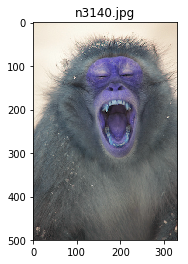

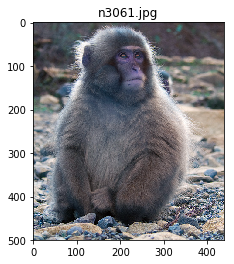

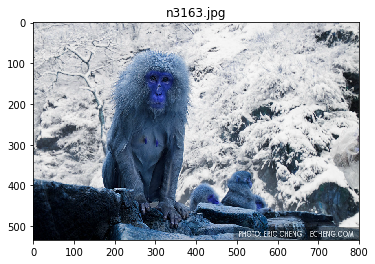

In [6]:
print(labels[3])
image_show(3,'n3')

 patas_monkey                  
(432, 650, 3)
n1
(853, 1280, 3)
n1
(550, 367, 3)
n1


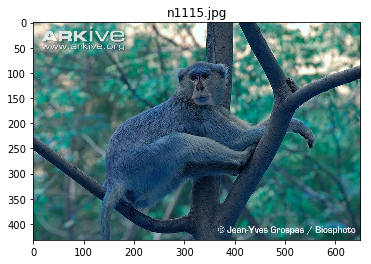

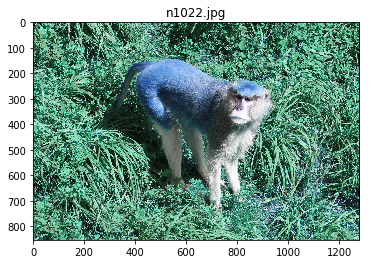

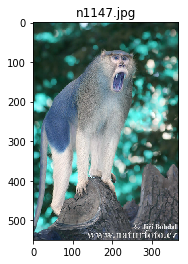

In [7]:
print(labels[1])
image_show(3,'n1')

 black_headed_night_monkey     
(480, 720, 3)
n8
(1120, 1200, 3)
n8
(2304, 3456, 3)
n8


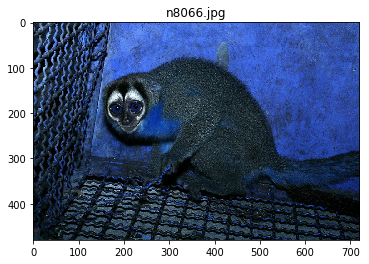

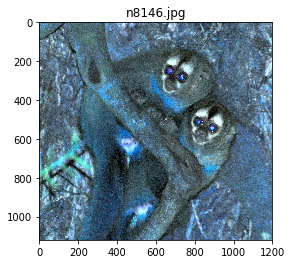

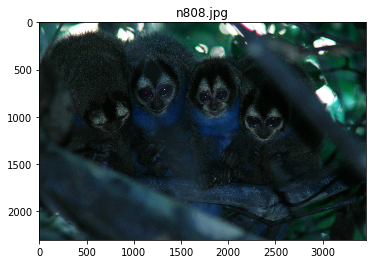

In [8]:
print(labels[8])
image_show(3,'n8')

 common_squirrel_monkey        
(374, 704, 3)
n7
(295, 446, 3)
n7
(1118, 1491, 3)
n7


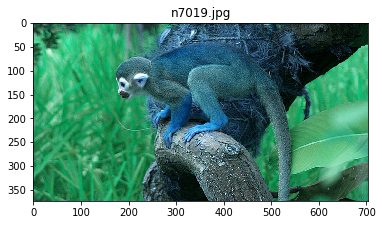

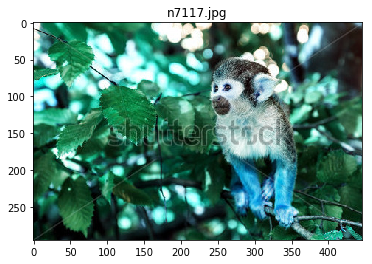

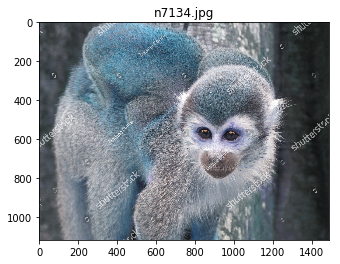

In [9]:
print(labels[7])
image_show(3,'n7')

### Preprocessing: creo i data generator per fornire i dati in batch al modello. Si effettua anche data augumentation.

In [6]:
height=299      #Misura dei pixel necessaria per l'architettura Xception
width=299
channels=3
batch_size = 64
num_classes = 10
data_augmentation = True

In [7]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split= 0.2,    #Grazie a questo parametro, il 20% del train verrà utilizzato come validation
        fill_mode='nearest')

#### Train Generator

In [8]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=1234,
                                                    shuffle=True,
                                                    subset= 'training',
                                                    class_mode='categorical')

Found 880 images belonging to 10 classes.


#### Validation Generator

In [9]:
validation_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=1234,
                                                    shuffle=True,
                                                    subset= 'validation',
                                                    class_mode='categorical')

Found 217 images belonging to 10 classes.


#### Test Generator

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=1234,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 272 images belonging to 10 classes.


### Modello

In [15]:
pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3), pooling= 'max')

### E' stata scaricata l'architettura Xception, con i pesi pre addestrati su imagenet. La parte fully-connected è stata esclusa. Verrà modellata su misura in seguito

In [16]:
pretrained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block9_sepconv1 (SeparableConv2 (None, 19, 19, 728)  536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 19, 19, 728)  0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 19, 19, 728)  536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 19, 19, 728)  2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

In [17]:
model = Sequential()

model.add(pretrained_model)
model.add(Dense(2048, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [18]:
model.layers[0].trainable = False

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [20]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', mode='min',patience=3, 
                              verbose=1, factor=0.5, min_lr=0.000001)

best_model = 'best_model.h5'
bestmodel = ModelCheckpoint(best_model, monitor = 'val_loss', verbose=1,
                            save_best_only=True, mode='min')

callbacks_list = [reduce_lr, bestmodel]

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [22]:
history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), # N° di batch del train
                              epochs=20, verbose = 1, 
                              validation_data = validation_generator, 
                              validation_steps = len(validation_generator), 
                              callbacks=callbacks_list)

Epoch 1/20
14/14 [==============================] - ETA: 3:45 - loss: 2.4324 - acc: 0.046 - ETA: 2:18 - loss: 2.3667 - acc: 0.093 - ETA: 1:55 - loss: 2.3287 - acc: 0.138 - ETA: 1:32 - loss: 2.2825 - acc: 0.154 - ETA: 1:16 - loss: 2.2604 - acc: 0.158 - ETA: 1:04 - loss: 2.2369 - acc: 0.163 - ETA: 53s - loss: 2.2185 - acc: 0.166 - ETA: 44s - loss: 2.1986 - acc: 0.17 - ETA: 36s - loss: 2.1769 - acc: 0.18 - ETA: 28s - loss: 2.1570 - acc: 0.18 - ETA: 20s - loss: 2.1382 - acc: 0.18 - ETA: 13s - loss: 2.1089 - acc: 0.20 - ETA: 6s - loss: 2.0914 - acc: 0.2063 - 125s 9s/step - loss: 2.0736 - acc: 0.2128 - val_loss: 1.7311 - val_acc: 0.4194

Epoch 00001: val_loss improved from inf to 1.73112, saving model to best_model.h5
Epoch 2/20
14/14 [==============================] - ETA: 1:13 - loss: 1.5708 - acc: 0.375 - ETA: 1:07 - loss: 1.5893 - acc: 0.335 - ETA: 1:02 - loss: 1.6079 - acc: 0.333 - ETA: 56s - loss: 1.6259 - acc: 0.308 - ETA: 50s - loss: 1.6849 - acc: 0.29 - ETA: 45s - loss: 1.6582 - acc

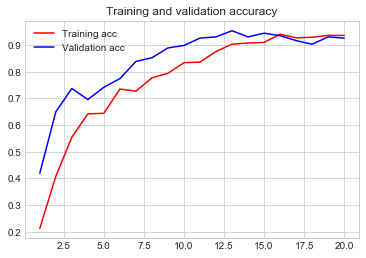

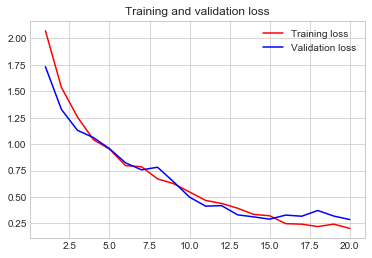

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
model.load_weights('best_model.h5')

In [25]:
model.evaluate_generator(test_generator)

[0.22130989628460476, 0.9558823529411765]

In [26]:
pred= model.predict_generator(test_generator)
predict = np.argmax(pred, axis = 1)

In [25]:
# Confusion Mtrix un pò diversa: 
def plot_confusion_matrix(cm, classes, target_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

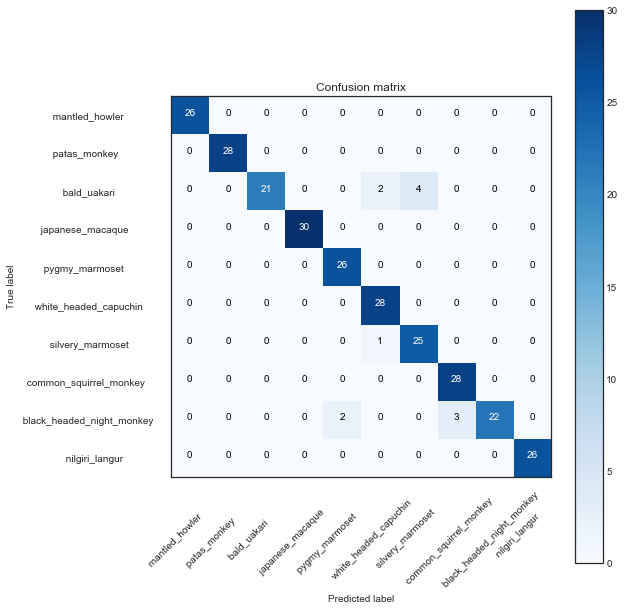

In [31]:
sns.set_style('white')
f, ax = plt.subplots(figsize= (9,9))
cfs_mtx = confusion_matrix(test_generator.classes, predict)
plot_confusion_matrix(cfs_mtx, classes=range(10), target_names= labels)

In [32]:
print(metrics.classification_report(test_generator.classes, predict,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       1.00      1.00      1.00        26
 patas_monkey                         1.00      1.00      1.00        28
 bald_uakari                          1.00      0.78      0.88        27
 japanese_macaque                     1.00      1.00      1.00        30
 pygmy_marmoset                       0.93      1.00      0.96        26
 white_headed_capuchin                0.90      1.00      0.95        28
 silvery_marmoset                     0.86      0.96      0.91        26
 common_squirrel_monkey               0.90      1.00      0.95        28
 black_headed_night_monkey            1.00      0.81      0.90        27
 nilgiri_langur                       1.00      1.00      1.00        26

                      micro avg       0.96      0.96      0.96       272
                      macro avg       0.96      0.96      0.95       272
                   weighted avg       0.96      0

### Il modello sviluppato raggiunge buone performance (0.955 sul test)

------------------------

### Si prova a migliorare il modello rendendo allenabile anche l'ultimo strato convoluzionale dell'applicazione Xception. Così facendo la rete si adatterà maggiormente all'estrazione delle features tipiche di questo dataset

In [11]:
pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3), pooling= 'max')

In [12]:
print('Numero layers Xception: {}'.format(len(pretrained_model.layers)))

Numero layers Xception: 133


In [13]:
#In questo modo freezzo tutti gli strati ad esclusione degli ultimi 4 strati
for i in range(0, len(pretrained_model.layers)):
    if i < 129:
        pretrained_model.layers[i].trainable = False

In [14]:
for layer in pretrained_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001C4CE9FDFD0> False
<keras.layers.convolutional.Conv2D object at 0x000001C4CEA8CF98> False
<keras.layers.normalization.BatchNormalization object at 0x000001C4CEA82D68> False
<keras.layers.core.Activation object at 0x000001C4CEA8CF28> False
<keras.layers.convolutional.Conv2D object at 0x000001C4CEC1BEB8> False
<keras.layers.normalization.BatchNormalization object at 0x000001C4CEA8C358> False
<keras.layers.core.Activation object at 0x000001C4CEBF56D8> False
<keras.layers.convolutional.SeparableConv2D object at 0x000001C4D548C828> False
<keras.layers.normalization.BatchNormalization object at 0x000001C4D5877E80> False
<keras.layers.core.Activation object at 0x000001C4D58FDEB8> False
<keras.layers.convolutional.SeparableConv2D object at 0x000001C4D7D45B00> False
<keras.layers.normalization.BatchNormalization object at 0x000001C4D7DB4518> False
<keras.layers.convolutional.Conv2D object at 0x000001C4D4F9EA20> False
<keras.layers.pooling.Ma

#### Si può osservare sopra che gli ultimi 4 layer, ovvero SeparableConv2D, BatchNormalization, Activation e GlobalMaxPooling sono addestrabili (True)

In [15]:
model2 = Sequential()

model2.add(pretrained_model)
model2.add(Dense(2048, activation = 'relu'))
model2.add(Dense(512, activation = 'relu'))
model2.add(Dropout(0.15))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dropout(0.15))
model2.add(Dense(32, activation = 'relu'))
model2.add(Dense(16, activation = 'relu'))
model2.add(Dense(10, activation = 'softmax'))

In [16]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

## Il modello sopra descritto è stato addestrato su colab

### Nel notebook assignment4 - parte 2 è possibile consultare il codice con cui sono stati trainati i seguenti pesi:

In [20]:
model2.load_weights('best_model2.h5')

In [22]:
model2.evaluate_generator(test_generator)

[0.05360566789065214, 0.9889705882352942]

In [23]:
pred= model2.predict_generator(test_generator)
predict = np.argmax(pred, axis = 1)

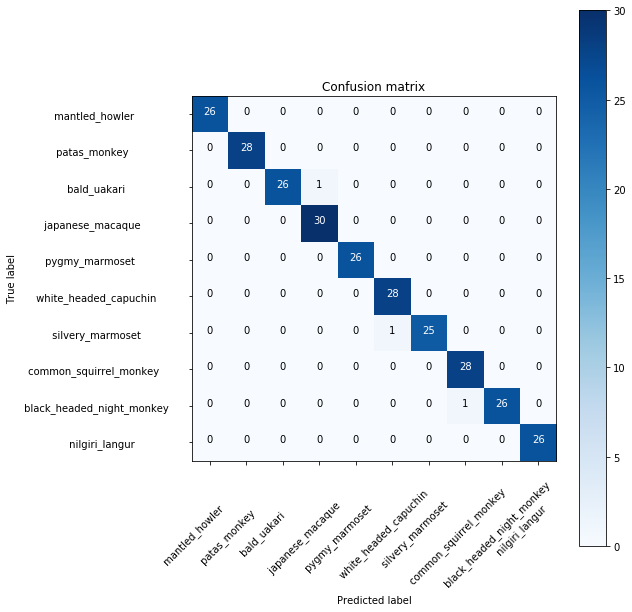

In [26]:
f, ax = plt.subplots(figsize= (9,9))
cfs_mtx = confusion_matrix(test_generator.classes, predict)
plot_confusion_matrix(cfs_mtx, classes=range(10), target_names= labels)

In [27]:
print(metrics.classification_report(test_generator.classes, predict,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       1.00      1.00      1.00        26
 patas_monkey                         1.00      1.00      1.00        28
 bald_uakari                          1.00      0.96      0.98        27
 japanese_macaque                     0.97      1.00      0.98        30
 pygmy_marmoset                       1.00      1.00      1.00        26
 white_headed_capuchin                0.97      1.00      0.98        28
 silvery_marmoset                     1.00      0.96      0.98        26
 common_squirrel_monkey               0.97      1.00      0.98        28
 black_headed_night_monkey            1.00      0.96      0.98        27
 nilgiri_langur                       1.00      1.00      1.00        26

                      micro avg       0.99      0.99      0.99       272
                      macro avg       0.99      0.99      0.99       272
                   weighted avg       0.99      0